# Libraries And Set Up

In [1]:
# Import necessary libraries
from dotenv import load_dotenv
import os

load_dotenv()

# Get environment variables as strings
llm_api_key = os.getenv('GROQ_API_KEY')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_PROJECT="pr-downright-hacienda-56"
from typing import TypedDict, List, Annotated, Literal
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages 
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.document_loaders import (
    PyPDFLoader,
    Docx2txtLoader, 
    UnstructuredPowerPointLoader, 
    CSVLoader, 
    UnstructuredExcelLoader
)
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_chroma import Chroma
import chromadb
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
import pandas as pd
from langgraph.graph import StateGraph, START, END
#from custom_agents_LG import agent_executor
from llm import get_llama_3dot3_70b_versatile,get_llama_3dot1_8b_instant,get_70b_8192
llm = get_llama_3dot3_70b_versatile()


c:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\footydata\Lib\site-packages\IPython\core\interactiveshell.py:3508: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


# Splitting and Vector DB For Research Paper

In [2]:
# initialise and set our vector database
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
client = chromadb.PersistentClient(path=".\LLM\Guided_langchain\chroma_db")
vectorstore = Chroma(
    client=client,
    embedding_function=embedding_function,
    collection_name="my_collection"
)
CHROMA_PATH = "./LLM/Guided_langchain/chroma_db"

def load_and_split_document(file_path: str) -> List[Document]:
    """Load and split a document into chunks."""
    if file_path.endswith('.pdf'):
        loader = PyPDFLoader(file_path)
    elif file_path.endswith('.docx'):
        loader = Docx2txtLoader(file_path)
    elif file_path.endswith(('.ppt', '.pptx')):
        loader = UnstructuredPowerPointLoader(file_path, mode="elements")
    elif file_path.endswith(('.xls', '.xlsx')):
        loader = UnstructuredExcelLoader(file_path)
    elif file_path.endswith('.csv'):
        loader = CSVLoader(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

    documents = loader.load()
    return text_splitter.split_documents(documents)

def get_vectorstore():
    """Get or create vectorstore with fresh client connection."""
    os.makedirs(CHROMA_PATH, exist_ok=True)
    client = chromadb.PersistentClient(path=CHROMA_PATH)
    return Chroma(
        client=client,
        embedding_function=embedding_function,
        collection_name="my_collection"
    )

def verify_document_loading(file_path: str):
    """Load, index, and verify document loading with detailed debugging."""
    print("\nSTEP 1: Loading document...")
    try:
        splits = load_and_split_document(file_path)
        print(f"Successfully split document into {len(splits)} chunks")
        print("\nFirst chunk preview:")
        if splits:
            print(splits[0].page_content[:200])
        
        print("\nSTEP 2: Resetting collection...")
        # Get fresh vectorstore connection
        vectorstore = get_vectorstore()
        
        # Get and delete existing documents
        existing_ids = vectorstore._collection.get()['ids']
        if existing_ids:
            vectorstore._collection.delete(ids=existing_ids)
        print("Collection reset complete")
        
        print("\nSTEP 3: Indexing document chunks...")
        for i, split in enumerate(splits):
            split.metadata['file_id'] = 1
            split.metadata['chunk_id'] = i
        
        vectorstore.add_documents(splits)
        print(f"Added {len(splits)} chunks to vectorstore")
        return True
    except Exception as e:
        print(f"ERROR during document processing: {str(e)}")
        import traceback
        traceback.print_exc()
        return False
    


In [3]:
file_path = r"C:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\data\multi_session_hias\Research Paper.docx"
#vecstore = verify_document_loading(file_path)

In [4]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})
retriever.invoke("How many athletes were in the study?")#,ConsistencyLevel="LOCAL_ONE")

[Document(metadata={'chunk_id': 0, 'file_id': 1, 'source': 'C:\\Users\\j.mundondo\\OneDrive - Statsports\\Desktop\\statsportsdoc\\Projects\\frequency_chat_PH\\data\\multi_session_hias\\Research Paper.docx'}, page_content='# Relationship Between High-Intensity Activity Metrics and Injury Risk in Professional Athletes: A Longitudinal Analysis\n\n\n\n## Abstract\n\n\n\nThis study investigated the relationship between high-intensity activity metrics and injury risk among professional athletes (n=427) over three seasons (2023-2025). We analysed acceleration, deceleration, and sprint patterns alongside metabolic power and dynamic stress load measurements to identify early warning indicators of potential injuries and recovery patterns.\n\n\n\n## Introduction\n\n\n\nUnderstanding the relationship between high-intensity activities and injury risk is crucial for modern sports science. Previous research has suggested correlations between workload metrics and injury occurrence, but few studies hav

# Create A Router

In [5]:
# Data Model
class Router(BaseModel):
    """Route the user's query to the relevant datasource."""

    datasource : Literal["vectorstore", "comparison_tool"]= Field(
        ...,
        description="Given a user's question choose to route it to the vectorstore to compare is to research thresholds, or use a tool to compare it to the player's own previous data"
    )

# We always want out output to match what the router expects
structured_llm_router = llm.with_structured_output(Router)
# Prompt
system = """You are an expert at routing a user question to a vectorstore which containts research data and thresholds  
or to an LLM with tools to compare the players input against his own historical data.
The vectorstore contains documents related a research paper about player workloads and their relationship to injury. They contain general thresholds.
Use the vectorstore for questions on these topics. Otherwise, use the agent tools to compare the players own data against their prior sessions."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "how many athletes were involved in the study?"}
    )
)
print(question_router.invoke({"question": "has Lee increased his workload?"}))

datasource='vectorstore'
datasource='comparison_tool'


# Create The Tooled Agent

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from llm import get_llama_3dot3_70b_versatile,get_llama3_8b_8192,get_70b_8192
from preprocess_df import full_preprocess
from langchain_multiplayer_tools import ComparePlayerMetrics, ComparePlayerSessions,ComparePlayerSessionsDictionary
from langchain.agents import AgentExecutor, create_tool_calling_agent
import pandas as pd
# # ruairi
# # stevie b
# # lee
# # kolo
# # flanno
# # jmce
# # fish
# # rocko
# # hawk
# # beattie
# # j carnegie
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate
from llm import get_llama_3dot3_70b_versatile, get_llama_3dot1_8b_instant
import pandas as pd
from pathlib import Path
from typing import List, Dict, Optional, Type, Any


def load_session_data(data_directory: str) -> Dict[str, pd.DataFrame]:
    """
    Load multiple session CSV files from a directory.
    
    Args:
        data_directory (str): Path to directory containing session CSV files
        
    Returns:
        Dict[str, pd.DataFrame]: Dictionary of DataFrames with session dates as keys
    """
    session_data = {}
    data_path = Path(data_directory)
    
    for csv_file in data_path.glob("*.csv"):
        # Extract date from filename (assuming format includes date)
        # Modify this based on your actual filename format
        date_str = csv_file.stem.split(" ")[0]  # Adjust splitting logic as needed
        
        # Load and preprocess the DataFrame
        df = pd.read_csv(csv_file)
        df = full_preprocess(df)  # Your preprocessing function
        
        session_data[date_str] = df
    
    return session_data

# Load session data
data_directory = r"C:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\data\multi_session_hias"
session_data = load_session_data(data_directory)

# Initialize the tool with your session data
#compare_player_sessions = ComparePlayerSessions(session_data=session_data)
compare_player_sessions_=ComparePlayerSessionsDictionary(session_data=session_data)
# Initialize the LLM
llm = get_llama_3dot1_8b_instant()#get_llama_3dot1_8b_instant()#get_llama3_8b_8192()#get_llama_3dot3_70b_versatile()

# Create the prompt template
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a sports performance analyst assistant specialising in analysing 
        player metrics across different training sessions.
        
        When analysing a player's performance across sessions:
        1. Extract the player name from the user's query
        2. Use the compare_player_sessions tool to analyse their performance
        3. Identify trends and patterns across sessions
        4. Highlight significant changes or improvements
        5. Provide insights about performance consistency and development
        
        Focus on:
        - Changes in activity distribution between sessions
        - Trends in performance metrics
        - Variations in metabolic power and stress loads
        - Time-based pattern changes
        - Overall performance trajectory
        
        Present the insights in a python dictionary.
        
        Your only output will be a python dictionary with the player metrics.

        CRITICAL : aside from the python dictionary, no additional words should be given

        """
    ),
    ("placeholder", "{chat_history}"),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

# Create the agent
agent = create_tool_calling_agent(
    llm=llm,
    tools=[compare_player_sessions_],
    prompt=prompt
)

# Create the agent executor
agent_executor = AgentExecutor(
    agent=agent,
    tools=[compare_player_sessions_],
   #verbose=True
)
# print("---")
# x= agent_executor.invoke({
#         "input": "analyse Lee's performance across all available sessions and provide his metrics as a dictionary"
#     })#["output"]
# print("***")
# print("New session_data structure:")
# for key, df in session_data.items():
#     print(f"Key: {key}")
#     print(f"Players in session: {df['Player'].unique()}")
    

Preprocessing completed successfully
Preprocessing completed successfully
Preprocessing completed successfully


# State For State Management

In [7]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function in the annotation defines how the state should be updated. 
    #in this case append messages rather than overwrite
   # messages : Annotated[list, add_messages] # Everytime we get a new message, we update our state. 
   # question: str <---- removed as we have the messages list, might need to revisit
    context: List[Document]
    player_metrics: str
    answer: str
    player_name: str
# graph_builder =  StateGraph(State)
# graph_builder

# Create Langraph Graphs

In [8]:
def retrieve(state):
    print("---RETRIEVE---") 
    documents = retriever.invoke(state["question"])
    return {
        "context": documents,
        "player_metrics": "",  # Empty but required
        "answer": "",
        "player_name": state.get("player_name", "")
    }

def player_metrics_tool(state):
    print("---PLAYER METRICS---")
    metrics = agent_executor.invoke({
        "input": f"Get {state['player_name']}'s metrics"
    })["output"]
    return {
        "context": state["context"],
        "player_metrics": metrics,
        "answer": "",
        "player_name": state["player_name"]
    }

In [18]:
def route_question(state):
   """Route question to comparison tool or vectorstore"""
   print("---ROUTE QUESTION---")
   question = state["context"]
   source = question_router.invoke({"question": question})
   if source.datasource == "comparison_tool":
       print("---ROUTE QUESTION TO AGENT---")
       return "comparison_tool"
   elif source.datasource == "vectorstore":
       print("---ROUTE QUESTION TO RAG---") 
       return "vectorstore"

In [19]:
# Graph nodes
def extract_player_name(question: str) -> str:
    """Extract player name from the question using the LLM."""
    name_extraction_prompt = """
    Extract the player name(s) from the following question. 
    If no specific player is mentioned, return None.
    Only return the name(s) without any additional text.
    
    Question: {question}
    """
    
    prompt = PromptTemplate.from_template(name_extraction_prompt)
    messages = prompt.invoke({"question": question})
    response = llm.invoke(messages).content.strip()
    
    return response if response.lower() != "none" else None

def get_player_metrics(player_name: str) -> dict:
    """Get metrics for a specific player."""
    return agent_executor.invoke({
        "input": f"Get {player_name}'s metrics as a dictionary format"
    })["output"]

def setup_initial_state(question: str) -> State:
    """Setup initial state without metrics - moved to separate node."""
    return {
        "question": question,
        "context": [],
        "player_metrics": "",
        "answer": "",
        "player_name": ""
    }

def extract_name_node(state: State):
    """Node for extracting player name."""
    player_name = extract_player_name(state["question"])
    return {"player_name": player_name}

def get_metrics_node(state: State):
    """Node for getting player metrics."""
    if not state["player_name"]:
        return {"player_metrics": "No specific player mentioned in query"}
    
    metrics = get_player_metrics(state["player_name"])
    return {"player_metrics": metrics}

def retrieve_node(state: State):
    """Node for retrieving relevant documents."""
    documents = []
    
    if state["player_metrics"] != "No specific player mentioned in query":
        metrics_doc = Document(
            page_content=f"Current Player Metrics for {state['player_name']}:\n{state['player_metrics']}",
            metadata={"source": "player_metrics"}
        )
        documents.append(metrics_doc)
    
    # Get research documents with specific queries
    research_queries = [
        f"injury risk thresholds for {state['player_name']}'s activity pattern",
        "critical thresholds for Dynamic Stress Load DSL",
        "metabolic power thresholds for injury risk",
        "recovery indicators and patterns research",
        "acceleration deceleration ratio research findings"
    ]
    
    for query in research_queries:
        retrieved_docs = vectorstore.similarity_search(
            query,
            k=2
        )
        documents.extend(retrieved_docs)
    
    return {"context": documents}

def generate_node(state: State):
    """Generate analysis with explicit reference to research data."""
    if state["player_metrics"] == "No specific player mentioned in query":
        return {"answer": "To analyze a player's injury risks, please specify a player name in your query."}
    
    # Separate metrics and research documents
    metrics_doc = None
    research_docs = []
    
    for doc in state["context"]:
        if doc.metadata.get("source") == "player_metrics":
            metrics_doc = doc
        else:
            research_docs.append(doc)
    
    # Format research findings
    research_findings = "\n\n".join([
        f"RESEARCH FINDING {i+1}:\n{doc.page_content}"
        for i, doc in enumerate(research_docs)
    ])
    
    analysis_prompt = """
    Using ONLY the provided research data and player metrics, conduct an injury risk analysis.
    
    PLAYER METRICS:
    {metrics}
    
    RESEARCH FINDINGS:
    {research}
    
    Analyze the following aspects, citing ONLY the provided research:
    1. Compare the player's metrics to the research thresholds
    2. Identify specific risk factors supported by the research
    3. Make recommendations based on the research findings
    
    Format your response with clear sections and evidence from the provided research.
    """
    
    messages = PromptTemplate.from_template(analysis_prompt).invoke({
        "metrics": metrics_doc.page_content if metrics_doc else "No metrics available",
        "research": research_findings
    })
    
    response = llm.invoke(messages)
    return {"answer": response.content}

In [20]:
# Define Agent Nodes

In [21]:
def extract_name_node(state: State):
    """Node for extracting player name."""
    player_name = extract_player_name(state["question"])
    return {"player_name": player_name}

def get_metrics_node(state: State):
    """Node for getting player metrics."""
    if not state["player_name"]:
        return {"player_metrics": "No specific player mentioned in query"}

In [22]:
from langgraph.graph import END, START, StateGraph

workflow = StateGraph(State)

# Add nodes 
workflow.add_node("Agent", retrieve)
workflow.add_node("vectorDB", get_player_metrics)

# Build graph with conditional edges
workflow.add_conditional_edges(
   START,
   route_question,
   {
       "comparison_tool": "Agent",
       "vectorstore": "vectorDB", 
   },
)

# Add end edges
workflow.add_edge("Agent", END)
workflow.add_edge("vectorDB", END)

# Compile
app = workflow.compile()

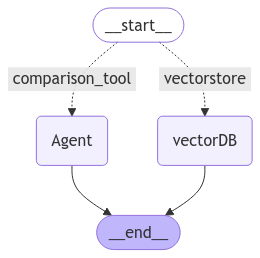

In [23]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
from pprint import pprint

# Run
inputs = {
    "question": "how have lees metrics changed in recent times?",
    "context": [],
    "player_metrics": "",
    "answer": "",
    "player_name": "Lee"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
"Node 'vectorDB':"
'\n---\n'
{'player_metrics': {'Avg Metabolic Power': {'count': 148,
                                            'max': 156.06,
                                            'mean': 43.192635135135134,
                                            'min': 2.41,
                                            'std': 24.524950071346165},
                    'Distance': {'count': 148,
                                 'max': 21.21,
                                 'mean': 6.405405405405405,
                                 'min': 0.36,
                                 'std': 4.574265396340822},
                    'Duration': {'count': 148,
                                 'max': 4.2,
                                 'mean': 1.9452702702702702,
                                 'min': 0.7,
                                 'std': 0.7416963879507882},
                    'Dynamic Stress Load': {'count': 148,
                           